<h1><u>Whose going to Win in the Footy?</u></h1>

This project is must for me as I am a proud Bulldogs supporter. With the up and coming 2021 season about to begin (as of writing) I want to find out how my team will match up. Though, the last couple of seasons have been a bit below par, I'm hoping that with new players and with Trent Barrett as coach we can finish in the top 8. Hopefully by the end of the regular season this is true, so I'm keep my fingers crossed. 

Anyways, the main goal of this project is to predict, given two teams, which team is more likely to win given a bunch of different characteristics. Along with data cleaning and visualisation, we'll ultimately construct and put to the test a few ML models, primarily PyTorch models, to see what the model predicts. 

Dataset available at: https://www.aussportsbetting.com/data/historical-nrl-results-and-odds-data/ 

<h2>Load Packages</h1>

In [110]:
# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [111]:
# ! pip install openpyxl for pd.read_excel() to work
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import os 
import re
import datetime
import pickle

from scipy import stats # boxcox transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim import lr_scheduler
# from torch.utils.tensorboard import SummaryWriter
import copy

from livelossplot import PlotLosses

%matplotlib inline

sns.set(style='darkgrid')

<h2>Importing and Tidying the Data</h2>

In [112]:
df_nrl = pd.read_excel("NRL_2009-2020.xlsx", skiprows=1)

In [113]:
df_nrl.head()

,Date,Kick-off (local),Home Team,Away Team,Home Score,Away Score,Play Off Game?,Over Time?,Home Odds,Draw Odds,...,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close,Notes
0,2020-10-25,19:30:00,Penrith Panthers,Melbourne Storm,20,26,Y,NaN,2.24,19.22,...,34.5,1.91,2.00,2.02,2.00,1.91,1.82,1.91,1.82,NaN
1,2020-10-17,19:50:00,Penrith Panthers,South Sydney Rabbitohs,20,16,Y,NaN,1.38,23.20,...,43.5,1.91,1.87,1.91,1.87,1.91,1.91,1.95,1.95,NaN
2,2020-10-16,18:50:00,Melbourne Storm,Canberra Raiders,30,10,Y,NaN,1.45,21.40,...,42.5,1.95,1.91,2.00,1.91,1.87,1.85,1.91,1.91,Played at Suncorp Stadium
3,2020-10-10,19:50:00,Parramatta Eels,South Sydney Rabbitohs,24,38,Y,NaN,3.57,24.50,...,45.5,1.91,1.91,1.91,1.85,1.91,1.91,1.97,1.97,NaN
4,2020-10-09,19:50:00,Sydney Roosters,Canberra Raiders,18,22,Y,NaN,1.43,21.90,...,42.5,1.91,1.91,2.02,2.02,1.91,1.91,1.91,1.80,NaN


In [114]:
df_nrl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2380 entries, 0 to 2379
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     2380 non-null   datetime64[ns]
 1   Kick-off (local)         2380 non-null   object        
 2   Home Team                2380 non-null   object        
 3   Away Team                2380 non-null   object        
 4   Home Score               2380 non-null   int64         
 5   Away Score               2380 non-null   int64         
 6   Play Off Game?           108 non-null    object        
 7   Over Time?               90 non-null     object        
 8   Home Odds                2377 non-null   float64       
 9   Draw Odds                2377 non-null   float64       
 10  Away Odds                2377 non-null   float64       
 11  Bookmakers Surveyed      2377 non-null   float64       
 12  Home Odds Open           1576 non-

We'll only need the odds for the Home, Draw and Away Wins, we will also not worry about the Notes field.
Also, there looks like there is quite a few missing values, which will correct.

<h3>Unncessary Columns and Missing Values</h3>

In [115]:
# Dropping unncessary fields
df_nrl.drop(df_nrl.iloc[:, 11:49], axis=1, inplace=True)

In [116]:
# Checking missing values 
def missing_values(df):
    global df_mv_cols
    mv = df.isnull().sum().sort_values(ascending=False)
    percentage = round(mv / len(df) * 100, 2)  # rounded 2 dp
    df_mv = pd.concat([mv, percentage], axis=1, keys=['Total', 'Percentage'])
    if sum(mv > 0) != 0:
        df_mv = df_mv.loc[df_mv['Total'] > 0]
        df_mv_cols = df_mv.index.tolist()
        return df_mv
    else:
        return print("No Missing Values")

missing_values(df_nrl)

,Total,Percentage
Over Time?,2290,96.22
Play Off Game?,2272,95.46
Home Odds,3,0.13
Draw Odds,3,0.13
Away Odds,3,0.13


In [117]:
# Since there are so few entries with missing values for the 3 odds, we'll just drop them
odds_cols = ['Away Odds', 'Draw Odds', 'Home Odds']
df_nrl.dropna(subset=odds_cols, inplace=True)

In [118]:
# Inspecting the unique values for remaining cols with missing values
def print_uniques_for_mv_cols(df, mv_cols):
    for col in mv_cols:
        print(f'{col}:', '\n', df[col].unique()[0:15], '\n')
        
remaining_mv_cols = list(set(df_mv_cols) - set(odds_cols))
print_uniques_for_mv_cols(df_nrl, remaining_mv_cols)

Play Off Game?: 
 ['Y' nan] 

Over Time?: 
 [nan 'Y'] 



In [119]:
# Changing 'Y' and nan to 'Yes' and 'No' respectively
for col in ['Play Off Game?', 'Over Time?']:
    df_nrl[col].replace({np.nan: "No", 'Y': "Yes"}, inplace=True)

<h3>Changing Column Types</h3>

In [120]:
# Each value in Date field is a datetime but there is no time so we'll adjust for this
df_nrl['Date'] = df_nrl['Date'].apply(lambda x: x.date())

In [121]:
df_nrl['Date'].dtypes

dtype('O')

<h3>Renaming Columns and Values</h3>

In [122]:
# We'll first fix up the column names
for col in df_nrl.columns:
    print(col)

Date
Kick-off (local)
Home Team
Away Team
Home Score
Away Score
Play Off Game?
Over Time?
Home Odds
Draw Odds
Away Odds


In [123]:
df_nrl.rename(columns={'Kick-off (local)': 'Kick-off Time',
                       'Play Off Game?': 'Play-off Game',
                       'Over Time?': 'Over Time'},
             inplace=True)

To rename the values, will first separate this proces into 3 steps:
  * Step 1: Categorical features
  * Step 2: Numerical features

In [124]:
# Step 1: Categorical features:
def print_cat_values(df):
    for col in df.columns:
        if df[col].dtype in ['object', 'bool', ]:
            print(f'{col}:', '\n', df[col].unique()[0:15], '\n'
                  f'Number of unique values:', len(df[col].unique()), '\n')

print_cat_values(df_nrl)

Date: 
 [datetime.date(2020, 10, 25) datetime.date(2020, 10, 17)
 datetime.date(2020, 10, 16) datetime.date(2020, 10, 10)
 datetime.date(2020, 10, 9) datetime.date(2020, 10, 4)
 datetime.date(2020, 10, 3) datetime.date(2020, 10, 2)
 datetime.date(2020, 9, 27) datetime.date(2020, 9, 26)
 datetime.date(2020, 9, 25) datetime.date(2020, 9, 24)
 datetime.date(2020, 9, 20) datetime.date(2020, 9, 19)
 datetime.date(2020, 9, 18)] 
Number of unique values: 1327 

Kick-off Time: 
 [datetime.time(19, 30) datetime.time(19, 50) datetime.time(18, 50)
 datetime.time(16, 5) datetime.time(17, 40) datetime.time(14, 0)
 datetime.time(19, 35) datetime.time(17, 30) datetime.time(15, 0)
 datetime.time(19, 55) datetime.time(18, 0) datetime.time(18, 30)
 datetime.time(17, 50) datetime.time(19, 0) datetime.time(17, 15)] 
Number of unique values: 49 

Home Team: 
 ['Penrith Panthers' 'Melbourne Storm' 'Parramatta Eels' 'Sydney Roosters'
 'South Sydney Rabbitohs' 'Canberra Raiders' 'St George Dragons'
 'New Zeal

First of all there are only 16 teams in the NRL, not 21, so we'll adjust for this. Then will rename the team names to there mascot names.


In [125]:
# Renaming NRL teams
len(df_nrl['Home Team'].unique() == df_nrl['Away Team'].unique())

21

Great, the Home Team and Away Team names are exactly the same.

In [126]:
df_nrl['Home Team'].unique()

array(['Penrith Panthers', 'Melbourne Storm', 'Parramatta Eels',
       'Sydney Roosters', 'South Sydney Rabbitohs', 'Canberra Raiders',
       'St George Dragons', 'New Zealand Warriors', 'Wests Tigers',
       'Cronulla Sharks', 'Canterbury Bulldogs', 'Gold Coast Titans',
       'Brisbane Broncos', 'Newcastle Knights', 'Manly Sea Eagles',
       'North QLD Cowboys', 'Manly-Warringah Sea Eagles',
       'Canterbury-Bankstown Bulldogs', 'Cronulla-Sutherland Sharks',
       'North Queensland Cowboys', 'St. George Illawarra Dragons'],
      dtype=object)

In [127]:
# There are some different names for the same club, but we only need the last word of each string
for team in ['Home Team', 'Away Team']:
    df_nrl[team] = df_nrl[team].apply(lambda x: x.split()[-1])

In [128]:
print(df_nrl['Home Team'].nunique())

16


In [129]:
# Step 2: Numerical Features
df_nrl.describe()

,Home Score,Away Score,Home Odds,Draw Odds,Away Odds
count,2377.000000,2377.000000,2377.000000,2377.000000,2377.000000
mean,22.030711,18.870004,1.920825,21.543324,2.577812
std,11.196154,10.350524,0.856685,3.145586,1.298421
min,0.000000,0.000000,1.010000,15.690000,1.040000
25%,14.000000,12.000000,1.400000,19.650000,1.680000
50%,20.000000,18.000000,1.640000,20.780000,2.300000
75%,29.000000,24.000000,2.230000,22.410000,3.010000
max,64.000000,68.000000,11.570000,47.400000,15.260000


In [130]:
# Just to be sure lets check that all numerical column values are definitely digits
numerical_cols = df_nrl.describe().columns.tolist()

# Checks int/float columns for any occurrences of non-digits (excluding period for floats)
def check_for_non_digits(df, num_cols):
    non_digits = []
    for col in num_cols:
        for value in df[col]:
            if bool(re.match('[0-9]+\.*[0-9]*', str(value))):
                pass
            else:
                non_digits.append(f'{col}: {value}')
    if len(non_digits) == 0:
        print("No non-numeric characters")
    else:
        print(non_digits)
        
check_for_non_digits(df_nrl, numerical_cols)

No non-numeric characters


<h3>Finishing Touches</h3>

In [131]:
# Let's reset the index, since this doesn't happen when we delete rows.
df_nrl.reset_index(drop=True, inplace=True)

<h2>Exploratory Data Analysis</h2>

In [132]:
# Making a copy of the data for next step
df_vis = df_nrl.copy()

In [133]:
# Making dict to specify team colors
team_colors = {
    'Panthers': 'black',
    'Storm': 'purple',
    'Eels': 'yellow',
    'Roosters': 'red',
    'Rabbitohs': 'green',
    'Raiders': 'lightgreen',
    'Dragons': 'white',
    'Warriors': 'grey',
    'Tigers': 'orange',
    'Sharks': 'dodgerblue',
    'Bulldogs': 'blue',
    'Titans': 'deepskyblue',
    'Broncos': 'maroon',
    'Knights': 'red',
    'Eagles': 'brown',
    'Cowboys': 'darkblue'
}

<h2 style="color:rgba(18,211,241,0.7)">Does the Favourite always win?</h2>

In [134]:
# We'll make a new column that indiciates:
### Whether the home team was the favourite (H) or the away team (A)
### I made the assumption that if the odds were the same, home team is the favourite due to home field advantage
df_vis['Favourite'] = np.where(df_vis['Home Odds'] <= df_vis['Away Odds'],'H','A')

### If the Home Team won (H), Away team won (A) or if the match was a Draw (D)
df_vis['Winner'] = np.where(df_vis['Home Score'] == df_vis['Away Score'], 'D', 
                            np.where(df_vis['Home Score'] > df_vis['Away Score'], 'H', 'A'))

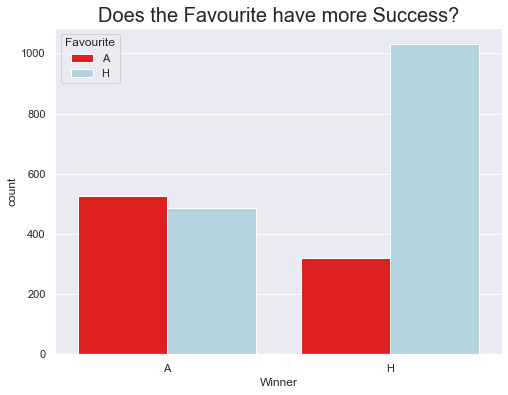

In [135]:
plt.figure(figsize=(8,6))
sns.countplot(x='Winner',
              hue='Favourite',
              data=df_vis[df_vis['Winner'] != 'D'],
              palette={'H':'lightblue', 'A':'red'})
plt.title('Does the Favourite have more Success?', fontsize=20);

If the home team won then more often than not they were the favourite about 75% of the time. On the other hand, if the away team won, they were regarded as the favourite but only a little over 50% of the time. 

<h2 style="color:rgba(18,211,241,0.7)">Which team has been most successful in the regular season 2009?</h2>

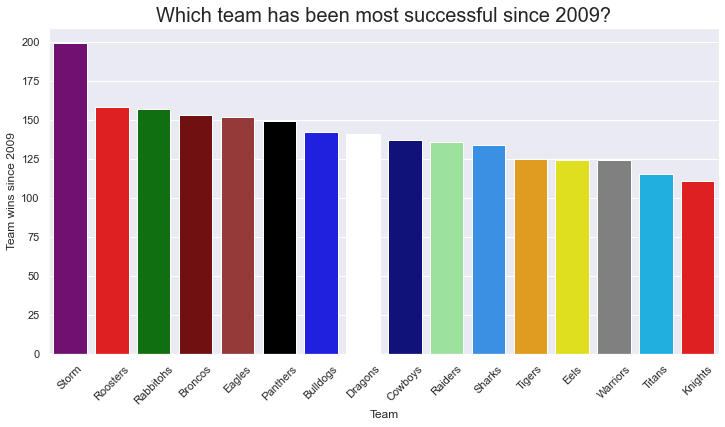

In [136]:
home_team_winner = df_vis['Home Team'][(df_vis['Winner'] == 'H') & (df_vis['Play-off Game'] == 'No')].value_counts()
away_team_winner = df_vis['Away Team'][(df_vis['Winner'] == 'A') & (df_vis['Play-off Game'] == 'No')].value_counts()

team_with_most_wins = home_team_winner + away_team_winner

team_wins_since_2009 = (
    team_with_most_wins
    .to_frame(name='Number_of_wins')
    .reset_index()
    .rename(columns={'index':'Team'})
    .sort_values(by='Number_of_wins', ascending=False)
)
    
plt.figure(figsize=(12,6))
sns.barplot(x='Team',
            y='Number_of_wins',
            data=team_wins_since_2009,
            palette=team_colors)
plt.xticks(rotation=45)
plt.ylabel('Team wins since 2009')
plt.title('Which team has been most successful since 2009?', fontsize=20);

No surprise, the Melbourne Storm have the most wins. Having the likes of Cameron Smith, Cooper Cronk and Billy Slater all those years its no wonder why there number 1. Secondly, the Roosters don't come as a surprise as well. Their last few seasons have been mostly successful winning back-to-back-to-back minor premierships in 2013, 2014 and 2015. Having Tedesco down fullback does help. 

Though, in last place we see the knights with the least amount of wins. It has only been the last few seasons since Mitchell Pearce has come across from the Roosters and with the addition of Kalyn Ponga have the Knights started to play better footy.

<h2 style="color:rgba(18,211,241,0.7)">Whose played and been the most successful in playoff games?</h2>

In [137]:
df_vis_playoffs = df_vis[df_vis['Play-off Game'] == 'Yes']

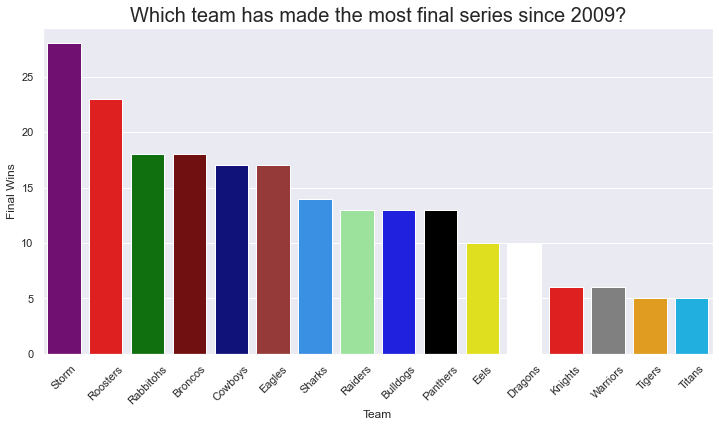

In [138]:
team_final_wins = (
    pd.concat([df_vis_playoffs['Home Team'], 
               df_vis_playoffs['Away Team']], ignore_index=True)
      .value_counts(ascending=False)
)

team_final_wins_df = (
    team_final_wins
    .to_frame(name='Number_of_wins')
    .reset_index()
    .rename(columns={'index':'Team'})
)

plt.figure(figsize=(12,6))
sns.barplot(x='Team',
            y='Number_of_wins',
            data=team_final_wins_df,
            palette=team_colors)
plt.xticks(rotation=45)
plt.ylabel('Final Wins')
plt.title('Which team has made the most final series since 2009?', fontsize=20);

Again, the Melbourne Storm have been the most successful team in the final series managing to take home the premiership in years 2012, 2017 and just recently in 2020. The Roosters with the second most wins have also managed to take home the premiership title 3 times like the Storm in years 2013, 2018 and 2019, though the Storm did make it to the finals twice, compared to the Roosters once. 

On the other side of the spectrum, we see the lonely Titans and Tigers only having 5 wins a piece. The tigers haven't really made a good finals run since 2005 when Benji Marshall was at his peak, whereas the titans have just been dismal, though 2021 does look like a better season on paper for them, but we will see in the coming weeks.

<h2 style="color:rgba(18,211,241,0.7)">Which teams have been the best (and worst) in offense in the regular season?</h2>

In [139]:
df_vis_reg = df_vis[df_vis['Play-off Game'] == 'No']

home_team_score_date = (
    df_vis_reg[['Home Team', 'Home Score', 'Date']]
    .rename(columns={'Home Team': 'Team', 'Home Score': 'Score'})
)

away_team_score_date = (
    df_vis_reg[['Away Team', 'Away Score', 'Date']]
    .rename(columns={'Away Team': 'Team', 'Away Score': 'Score'})
)

team_score_date = pd.concat([home_team_score_date, away_team_score_date], ignore_index=True)

# We'll change Date column to a Season Column, where 2009 = season 1 and 2020 = season 12
team_score_date['Date'] = team_score_date['Date'].apply(lambda date: date.year)

# Renaming 'Date' field name to 'Season' 
### Note: Obviously the 2009 season is not season 1, but for simplicity we'll assume that is the case
team_score_date.rename(columns={'Date': 'Season'}, inplace=True)

In [140]:
team_for_in_season = team_score_date.groupby(['Season', 'Team']).sum().reset_index()
best_offensive_team = team_for_in_season.iloc[team_for_in_season.groupby('Season')['Score'].idxmax(), ]
worst_offensive_team = team_for_in_season.iloc[team_for_in_season.groupby('Season')['Score'].idxmin(), ]

In [141]:
best_offensive_team['Season'] = best_offensive_team['Season'].astype(str) + '-' + best_offensive_team['Team']
best_offensive_team = best_offensive_team.drop('Team', axis=1)

worst_offensive_team['Season'] = worst_offensive_team['Season'].astype(str) + '-' + worst_offensive_team['Team']
worst_offensive_team = worst_offensive_team.drop('Team', axis=1)

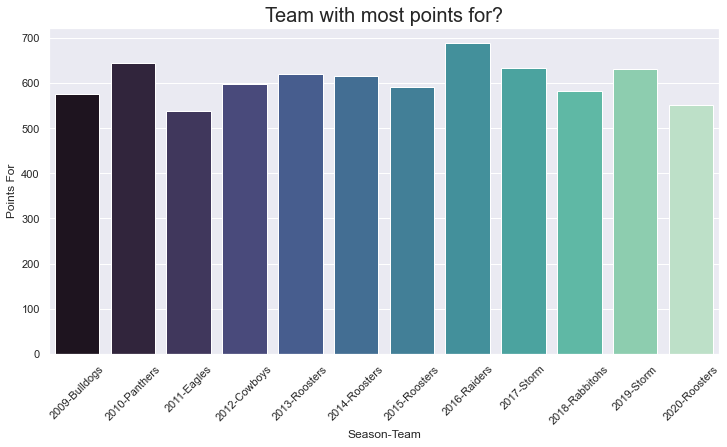

In [142]:
# Teams with BEST offensive
plt.figure(figsize=(12,6))
sns.barplot(x='Season',
            y='Score',
            data=best_offensive_team,
            palette="mako")
plt.xticks(rotation=45)
plt.xlabel('Season-Team')
plt.ylabel('Points For')
plt.title('Team with most points for?', fontsize=20);

The Roosters have had the best offense 4 out of the last 12 seasons. The seasons of 2013 to 2015 they were minor premiers, so no surprise. Though, what stands out to me is the Raiders 2016 season almost accumulating 700 regular season points for, however, comparing this to the Eels 2001 season where they accumulated 981 points for does dwarf this figure. Also, if you look at the 2009 season, had to throw that in there, the Bulldogs had the best offense, hopefully this is the case in 2021, but I know this will be a big ask.

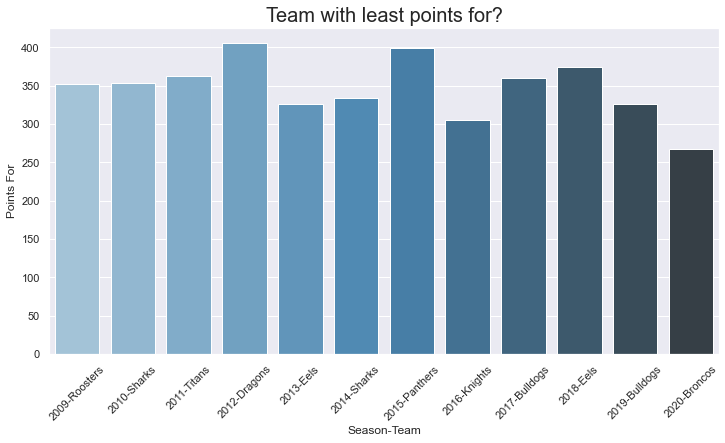

In [143]:
# Teams with WORST offensive
plt.figure(figsize=(12,6))
sns.barplot(x='Season',
            y='Score',
            data=worst_offensive_team,
            palette="Blues_d")
plt.xticks(rotation=45)
plt.xlabel('Season-Team')
plt.ylabel('Points For')
plt.title('Team with least points for?', fontsize=20);

Looking at all the teams, can't go without saying how dismal the Broncos were in the year just gone. They scored the least amount of points by quite some margin across the other 11 years. Also, it's a big turn around for the Sharks from 2014 scoring the least amount of points to going on to win the premiership in 2016. Though, in all due respect, their coach, Shane Flanagan (at the time), was suspended the entire season and with the ongoing asada investigation that sure was no help.  

<h2 style="color:rgba(18,211,241,0.7)">What are 20 of the biggest upsets in monetary terms?</h2>

In [144]:
indexes = []

for index, row in df_vis.iterrows():
    if row['Winner'] == 'H':
        if row['Home Odds'] <= row['Away Odds']:
            indexes.append(False)
        else: 
            indexes.append(True)
    elif row['Winner'] == 'A':
        if row['Away Odds'] <= row['Home Odds']:
            indexes.append(False)
        else:
            indexes.append(True)
    else: # for Draws
        indexes.append(True) # appending draws as odds are always higher than both home and away odds

In [145]:
df_upsets = df_vis[indexes]
df_upsets['Upset Odds'] = (
    np.where(df_upsets['Winner'] == 'H', df_upsets['Home Odds'], 
             np.where(df_upsets['Winner'] == 'A', df_upsets['Away Odds'], df_upsets['Draw Odds']))
)
df_upsets1 = df_upsets.iloc[:, [0,2,3,4,5,12,13]].sort_values('Upset Odds', ascending=False).head(20)
df_upsets1

,Date,Home Team,Away Team,Home Score,Away Score,Winner,Upset Odds
2231,2009-08-01,Panthers,Warriors,32,32,D,23.39
821,2016-08-01,Titans,Sharks,18,18,D,23.19
1115,2015-04-25,Knights,Cowboys,26,26,D,22.20
2325,2009-04-25,Storm,Warriors,14,14,D,21.75
2301,2009-05-22,Eels,Rabbitohs,16,16,D,21.75
954,2016-03-19,Knights,Raiders,24,24,D,21.37
1430,2013-08-02,Knights,Broncos,18,18,D,20.88
1649,2012-07-09,Sharks,Roosters,14,14,D,20.81
1889,2011-06-03,Eels,Dragons,14,14,D,20.69
1496,2013-05-20,Storm,Eagles,10,10,D,20.00


As expected, the biggest bang for your buck is when a team has a draw. Now, I'd oppose to betting on the draw since it is highly unlikely to occur, but if your feeling lucky why not? 
Disregarding the draws, what stands out to me is the Dragons being the favourite against the Rabbitohs back in 2009-08-29. The Rabbits were paying $6.45 for the win and absolutely annihiliated there opponent. 

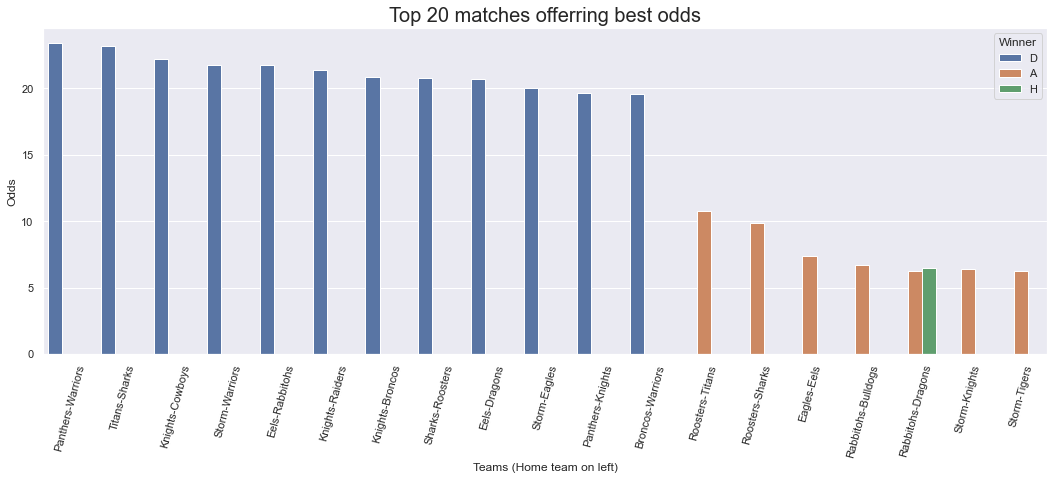

In [146]:
# Visual perspective of the biggest odds
df_upsets2 = (
    df_upsets1.iloc[:, [1,2,5,6]]
              .assign(Home_Away=lambda x: x['Home Team'] + "-" + x['Away Team'])
              .drop(['Home Team', 'Away Team'], axis=1)
)

plt.figure(figsize=(18,6))
sns.barplot(x='Home_Away',
            y='Upset Odds',
            data=df_upsets2,
            hue='Winner')
plt.xticks(rotation=75)
plt.xlabel('Teams (Home team on left)')
plt.ylabel('Odds')
plt.title('Top 20 matches offerring best odds', fontsize=20);

<h2 style="color:rgba(18,211,241,0.7)">Want entertainment? Which kick-off times on average yield the more points scored?</h2>

In [147]:
# First let's have a look at occurrences of kick-times times
df_vis['Kick-off Time'].value_counts(sort=True)

19:30:00    318
15:00:00    263
19:35:00    244
17:30:00    238
14:00:00    236
19:00:00    215
19:50:00    168
16:00:00    144
18:00:00     83
19:45:00     74
19:55:00     57
16:05:00     50
18:30:00     50
19:40:00     36
16:10:00     30
20:00:00     25
17:00:00     23
20:05:00     21
16:30:00     15
20:30:00     14
19:05:00     13
20:35:00      6
18:10:00      5
17:50:00      4
19:15:00      4
18:50:00      4
13:00:00      4
20:45:00      3
15:30:00      3
18:35:00      3
14:10:00      2
19:20:00      2
17:40:00      2
18:45:00      2
18:15:00      2
20:10:00      1
18:55:00      1
19:10:00      1
12:00:00      1
19:25:00      1
17:15:00      1
15:10:00      1
13:30:00      1
21:00:00      1
17:10:00      1
17:45:00      1
17:35:00      1
16:40:00      1
18:40:00      1
Name: Kick-off Time, dtype: int64

Since there are so many different kick-off times, we'll take it that there must be at least 10 matches for a given kick-off time. Then, based on this we'll calculate the average points scored.

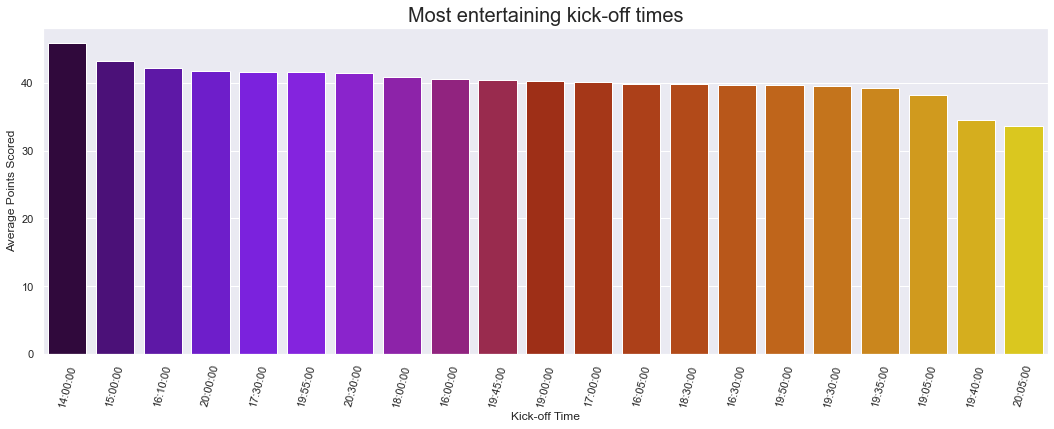

In [148]:
time_most_points = (
    df_vis.assign(Points_Scored=lambda x: x['Home Score'] + x['Away Score'])
          .groupby('Kick-off Time')
          .agg(['mean', 'count'])['Points_Scored']
          .round(2)
          .query('count >= 10')
          .sort_values('mean', ascending=False)
          .reset_index()
)

plt.figure(figsize=(18,6))
sns.barplot(x='Kick-off Time',
            y='mean',
            data=time_most_points,
            palette="gnuplot")
plt.xticks(rotation=75)
plt.xlabel('Kick-off Time')
plt.ylabel('Average Points Scored')
plt.title('Most entertaining kick-off times', fontsize=20);

In [149]:
# Plotly barplot of the above
# fig = px.bar(time_most_points, 
#              x='Kick-off Time', 
#              y='mean',
#              title='Most popular times for most combined points scored',
#              labels={'mean': 'Average Points Scored'},
#              height=500, 
#              width=800)
# fig.update_layout(
#     font_family="Courier New",
#     font_color="blue",
#     title_font_family="Times New Roman",
#     title_font_color="black",
#     legend_title_font_color="green",
#     title={'x':0.5, 'y':0.9}
# )
# fig.show()

If your after pure entertainment 2pm kick-off times are the ones for you. Though, whats funny is that should a match start 5 mins later at 2:05pm, these games happen to be the less interesting ones with the least amount of points scored. I guess 5 minutes does make a difference. For the matches ranging from 8pm to 7:35pm (from plot) there is only about a 2 point differential on average. 

<h2 style="color:rgba(18,211,241,0.7)">The spread of each teams home and away odds</h2>

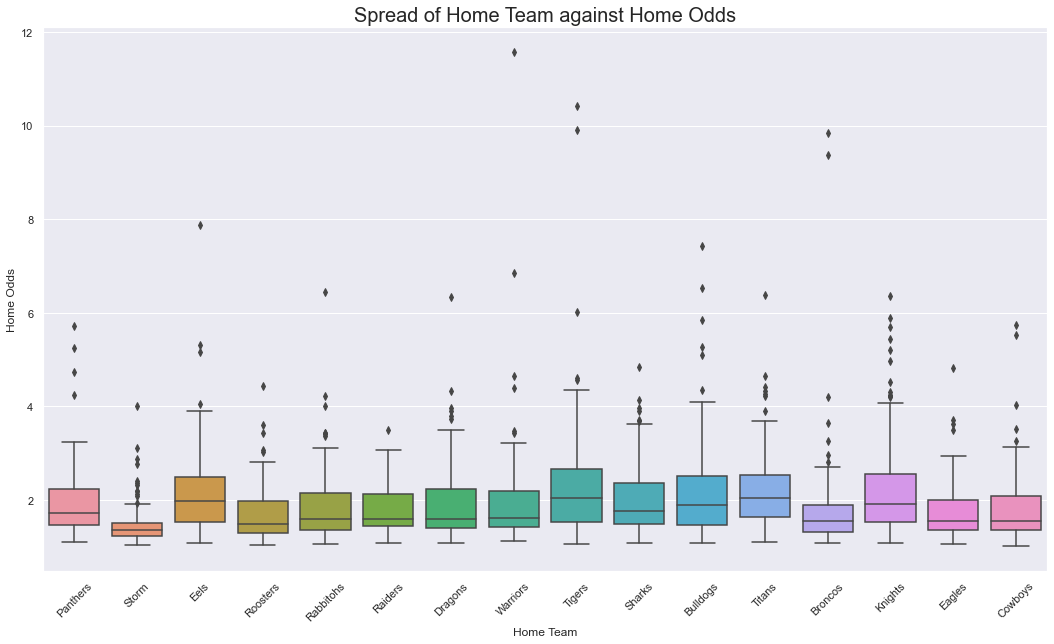

In [150]:
plt.figure(figsize=(18,10))
sns.boxplot(x="Home Team", y="Home Odds", data=df_vis)
plt.xticks(rotation=45)
plt.xlabel('Home Team')
plt.ylabel('Home Odds')
plt.title('Spread of Home Team against Home Odds', fontsize=20);

Before I get into anything, I can't believe the Warriors were paying almost $12 to win at there home ground on one occassion, lets see who they actually played and if they won. 

In [151]:
df_vis[df_vis['Home Odds'] > 11.50]

,Date,Kick-off Time,Home Team,Away Team,Home Score,Away Score,Play-off Game,Over Time,Home Odds,Draw Odds,Away Odds,Favourite,Winner
85,2020-07-25,15:00:00,Warriors,Roosters,10,18,No,No,11.57,41.0,1.04,A,A


Wow, this is only a recent game to, played at Gosford, and looking up the results on Google the Warriors actually led at halftime 10-6, would of been nail-biting having money on the Roosters to win at the half.

Anyways, across the 12 years worth of data, it's quite clear the Storm have been the favourites most of the time with the lowest payout for a home win. The Tigers on the other hand, well these home odds have been very volatile and no reason why as they have been poor most season since 2009.

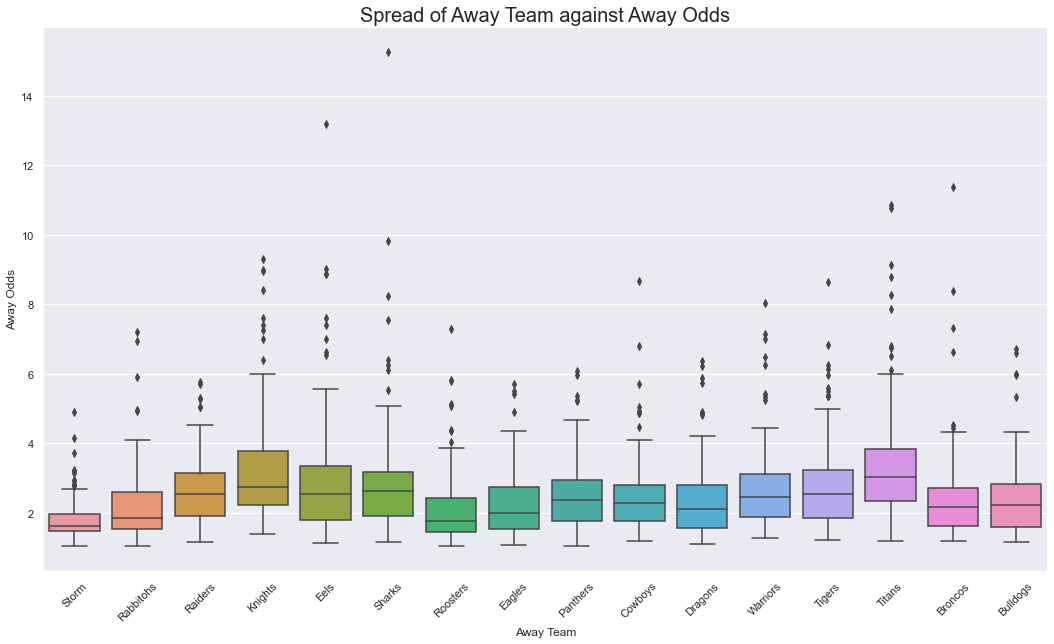

In [152]:
plt.figure(figsize=(18,10))
sns.boxplot(x="Away Team", y="Away Odds", data=df_vis)
plt.xticks(rotation=45)
plt.xlabel('Away Team')
plt.ylabel('Away Odds')
plt.title('Spread of Away Team against Away Odds', fontsize=20);

Again, the Storm have had the lowest payout the majority of the time being the away team which makes sense and on the other hand the tigers have had a lot of volatility in regards to there away odds. However, looking at the Sharks they were paying over $15 for the win at one stage, let's investigate how they went.

In [153]:
df_vis[df_vis['Away Odds'] > 15]

,Date,Kick-off Time,Home Team,Away Team,Home Score,Away Score,Play-off Game,Over Time,Home Odds,Draw Odds,Away Odds,Favourite,Winner
1191,2014-09-01,19:00:00,Cowboys,Sharks,20,19,No,Yes,1.01,47.4,15.26,H,H


Oh my word, this game went to overtime and the cowboys just won by a single point, crazy! It just goes to show you regardless of the big odds for some teams, every match is a risky bet.

<h2>Pre-Processing</h2>

<h3>Correlations</h3>

In [154]:
# We'll use df_vis data as it contains 2 extra columns in Favourite and Winner
df_cor = df_vis.copy()

In [155]:
# Firstly, encode categorical columns as integers, and get a glimpse of there values.
def enc_cat_features(df):
    dfc = df.copy()
    global df_cat_encoded
    for col in dfc.columns:
        if dfc[col].dtype in ['object', 'bool']:
            lab_enc = LabelEncoder()
            dfc[col] = lab_enc.fit_transform(dfc[col])
            lab_enc_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
            print(col, '\n', list(lab_enc_name_mapping.items())[0:20], '\n')
    df_cat_encoded = dfc

enc_cat_features(df_cor)

Date 
 [(datetime.date(2009, 3, 13), 0), (datetime.date(2009, 3, 14), 1), (datetime.date(2009, 3, 15), 2), (datetime.date(2009, 3, 16), 3), (datetime.date(2009, 3, 20), 4), (datetime.date(2009, 3, 21), 5), (datetime.date(2009, 3, 22), 6), (datetime.date(2009, 3, 23), 7), (datetime.date(2009, 3, 27), 8), (datetime.date(2009, 3, 28), 9), (datetime.date(2009, 3, 29), 10), (datetime.date(2009, 3, 30), 11), (datetime.date(2009, 4, 3), 12), (datetime.date(2009, 4, 4), 13), (datetime.date(2009, 4, 5), 14), (datetime.date(2009, 4, 6), 15), (datetime.date(2009, 4, 10), 16), (datetime.date(2009, 4, 11), 17), (datetime.date(2009, 4, 12), 18), (datetime.date(2009, 4, 13), 19)] 

Kick-off Time 
 [(datetime.time(12, 0), 0), (datetime.time(13, 0), 1), (datetime.time(13, 30), 2), (datetime.time(14, 0), 3), (datetime.time(14, 10), 4), (datetime.time(15, 0), 5), (datetime.time(15, 10), 6), (datetime.time(15, 30), 7), (datetime.time(16, 0), 8), (datetime.time(16, 5), 9), (datetime.time(16, 10), 10), (dat

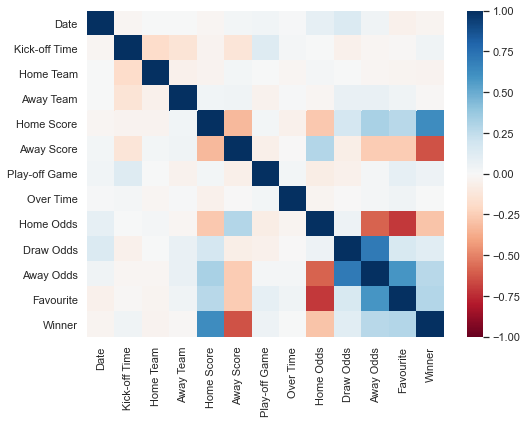

In [156]:
# Plot heatmap of the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_cat_encoded.corr(),
            vmin=-1,
            vmax=1,
            cmap='RdBu');

Home Score is highly positive correlated with Winner (as well as Favourite and Home Odds). Looking at the first visualisation from above, it was obvious that the home team wins approximately 75% of the time. On the other hand, we'd expect that Winner is negatively correlated with Away Score as is the case. 

Also Away Odds and Draw Odds seem to be highly positively correlated. This is because the odds for a draw is always going to be the highest out of the 3 and more cases than not the home team will be the favourite meaning the away odds will be greater, hence the draw odds will be even greater tending to a higher positive correlation.

For preciseness lets check the exact correlations below and above -0.5 and 0.5 respectively:

In [157]:
# Returns the correlation pairs where the correlation is > pv or < nv
def check_corr_values(df, pv, nv):
    for x in range(len(df)):
        for y in range(len(df)):
            if ((df.iloc[x, y] > pv) | (df.iloc[x, y] < nv)):
                if df.index[x] == df.index[y]:
                    pass
                elif x < y:
                    print(df.index[x], '-', df.index[y] + ': ', round(df.iloc[x, y], 5))
                    
check_corr_values(df_cat_encoded.corr(), 0.5, -0.5)

Home Score - Winner:  0.62786
Away Score - Winner:  -0.63823
Home Odds - Away Odds:  -0.58835
Home Odds - Favourite:  -0.70355
Draw Odds - Away Odds:  0.70463
Away Odds - Favourite:  0.58675


This just highlights the fact no two fields are perfectly correlated (i.e. > 0.9 or < -0.9)

<h3>Feature Selection</h3>

In [158]:
df_fs = df_vis.copy()

We'll drop the Date and Favourite fields as the former tells us nothing and the latter can be derived from Home and Away odds. Also we'll remove Home Score and Away Score as we want to predict which team wins, and obviously specifying these two the model will learn to adapt to the one with the highest score and always pick that team. Next, we'll drop the Over Time field as we don't know if the game will go to OT based on the start of the game.

In [159]:
# Drop fields 
drop_cols = ['Date', 'Favourite', 'Home Score', 'Away Score', 'Over Time']
df_fs.drop(drop_cols, axis=1, inplace=True)

<h3>Feature Engineering</h3>

In [160]:
df_fe = df_fs.copy()

In [161]:
# Checking number of unique values in categorical columns
def num_uniques_in_cat_cols(df):
    data = {}
    for col in df.columns:
        if df[col].dtype in ['object', 'bool']:
            data[col] = len(df[col].unique())
    data = sorted(data.items(), key=lambda item: item[1], reverse=True)
    for k,v in data:
        print(f'{k}: {v}')

num_uniques_in_cat_cols(df_fe)

Kick-off Time: 49
Home Team: 16
Away Team: 16
Winner: 3
Play-off Game: 2


We'll make 3 different datasets here:
  * Dataset 1: All label encoded
  * Dataset 2: As per Dataset 1 but Kick-off time grouped by 10 min intervals
  * Dataset 3: As per Dataset 1 but Home and Away Team will be dummy encoded and Kick-off Time be grouped by 10min intervals
  
Note: Over Time and Play-off Game having 2 values could be interchanged for dummy encoding


<h4 style="color:red">Dataset 1</h4>

In [162]:
# Dataset 1:
### Label encodes all categorical columns and returns a lookup dict to see what values got encoded to what integers 
def label_enc_cat_features(df):
    global encodings_ds1
    dfc = df.copy()
    encodings_ds1 = dict()
    for col in dfc.columns:
        if dfc[col].dtype in ['object', 'bool']:
            lab_enc = LabelEncoder()
            dfc[col] = lab_enc.fit_transform(dfc[col])
            lab_enc_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
            encodings_ds1[col] = lab_enc_name_mapping
    return dfc
    
df_fe1 = label_enc_cat_features(df_fe)
df_fe1_catEnc = encodings_ds1

For Datasets 2 and 3 we'll need to create a function that will encode the Kick-off Time field in 10 minute intervals where we'll include the lower limit but exclude the upper limit. Then, we'll transform the Kick-off Time field to integers ready for machine learning use.

<h4 style="color:red">Dataset 2</h4>

In [163]:
# Dataset 2:
df_fe2 = df_fe.copy()

In [164]:
def binning_encoding(df, col):
    global bins
    global encodings_ds2
    bins = []
    for x in np.linspace(720, 1260, 55):
        bins.append((x, x+10))
    encodings_ds2 = []
    time_in_mins = df[col].apply(lambda x: x.hour*60 + x.minute)
    for row in time_in_mins:
        for bin_ in bins:
            lb, ub = bin_
            if lb <= row < ub:
                encodings_ds2.append(int((lb - 720)/10))

binning_encoding(df_fe2, 'Kick-off Time')

In [165]:
# We'll also create a function to convert Kick-off Time to appropriate integer encoding
def time_to_integer_conversion(x):
    x = x.hour*60 + x.minute
    for bin_ in bins:
        lb, ub = bin_
        if lb <= x < ub:
            return int((lb - 720)/10)
    return print("Please type in a datetime.time() between 12pm and 9pm")

time_to_integer_conversion(datetime.time(21, 5))

54

In [166]:
# Encoding Kick-off Times to integers based on 10 min intervals 
df_fe2['Kick-off Time'] = encodings_ds2

In [167]:
# We'll label encode the remaining columns 
def label_enc_cat_features_2(df):
    global encodings_ds2_1
    dfc = df.copy()
    encodings_ds2_1 = dict()
    for col in dfc.columns:
        if dfc[col].dtype in ['object', 'bool']:
            lab_enc = LabelEncoder()
            dfc[col] = lab_enc.fit_transform(dfc[col])
            lab_enc_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
            encodings_ds2_1[col] = lab_enc_name_mapping
    return dfc
    
# Label encode categorical columns
df_fe2 = label_enc_cat_features_2(df_fe2)

# Key, Value mapping pairs
df_fe2_catEnc = encodings_ds2_1

<h4 style="color:red">Dataset 3</h4>

In [168]:
# Dataset 3
df_fe3 = df_fe.copy()

In [169]:
def binning_encoding_3(df, col):
    global bins_ds3
    global encodings_ds3
    bins_ds3 = []
    for x in np.linspace(720, 1260, 55):
        bins_ds3.append((x, x+10))
    encodings_ds3 = []
    time_in_mins = df[col].apply(lambda x: x.hour*60 + x.minute)
    for row in time_in_mins:
        for bin_ in bins_ds3:
            lb, ub = bin_
            if lb <= row < ub:
                encodings_ds3.append(int((lb - 720)/10))

binning_encoding_3(df_fe3, 'Kick-off Time')

In [170]:
# Encode 10 min intervals to integers
df_fe3['Kick-off Time'] = encodings_ds3

In [171]:
# Dummy encode Home Team and Away Team fields
df_fe3 = pd.get_dummies(df_fe3, columns=['Home Team', 'Away Team'])

In [172]:
# We'll label encode the remaining columns once again 
def label_enc_cat_features_3(df):
    global encodings_ds3_1
    dfc = df.copy()
    encodings_ds3_1 = dict()
    for col in dfc.columns:
        if dfc[col].dtype in ['object', 'bool']:
            lab_enc = LabelEncoder()
            dfc[col] = lab_enc.fit_transform(dfc[col])
            lab_enc_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
            encodings_ds3_1[col] = lab_enc_name_mapping
    return dfc
    
# Label encode categorical columns
df_fe3 = label_enc_cat_features_3(df_fe3)

# Key, Value mapping pairs
df_fe3_catEnc = encodings_ds3_1

<h3>Feature Scaling</h3>

In [173]:
# Make Copies of the 3 datasets
df_fs1 = df_fe1.copy()
df_fs2 = df_fe2.copy()
df_fs3 = df_fe3.copy()

X1 = df_fs1.drop(['Winner'], axis=1)
X2 = df_fs2.drop(['Winner'], axis=1)
X3 = df_fs3.drop(['Winner'], axis=1)
y = df_fs1['Winner']

# We'll also separate the data to Training, Validation and Testing
### Because there is so little data, I will only use 80/10/10 split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.10, random_state=1)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.10, random_state=2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.10, random_state=3)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.10, random_state=4)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.10, random_state=5)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3_train, y3_train, test_size=0.10, random_state=6)

We'll now apply 3 different feature scaling techniques:
  1. Boxcox + PCA
  2. Standardisation (excludes PCA fields)
  3. Normalisation (excludes PCA fields)
  
The first process requires continuous features to be normal, so we'll make use of kernel density plots for each continous feature and then apply a boxcox transformation (if necessary) to transform the data. Should the dtaa after the transformation look normal (or bell-shape) we'll apply PCA.

The second and third processes are obvious.

<h4 style="color:dodgerblue">Boxcox + PCA</h4>

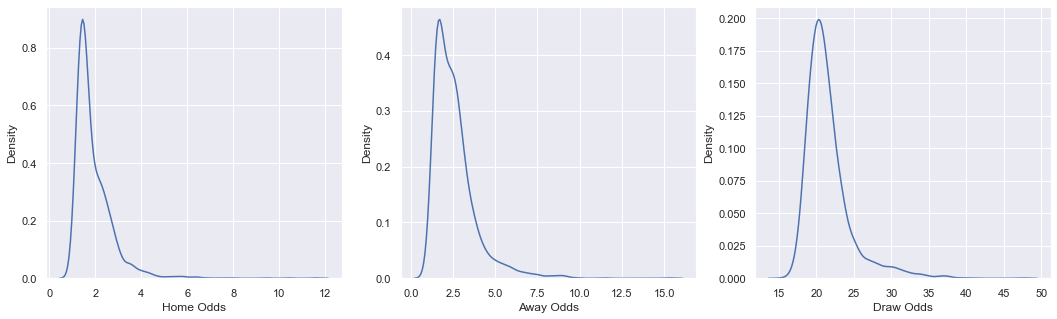

In [174]:
# The 3 datasets we made will have the exact same values for the 3 odds columns so we'll just use X1_train
fig, ax = plt.subplots(1, 3, figsize=(18,5))
sns.kdeplot(data=X1_train, x="Home Odds", ax=ax[0])
sns.kdeplot(data=X1_train, x="Away Odds", ax=ax[1])
sns.kdeplot(data=X1_train, x="Draw Odds", ax=ax[2]);

All 3 graphs are positive (or right) skewed. Let's apply a boxcox transformation to make the data more normal:

In [175]:
def boxcox(df):
    global optimal_lambdas
    global dfb
    dfb = df.copy()
    optimal_lambdas = dict()
    for col in dfb.columns:
        if dfb[col].dtype == 'float':
            xt, best_lambda = stats.boxcox(dfb[col])
            optimal_lambdas[col] = best_lambda
            dfb[col] = xt
    
boxcox(X1_train)

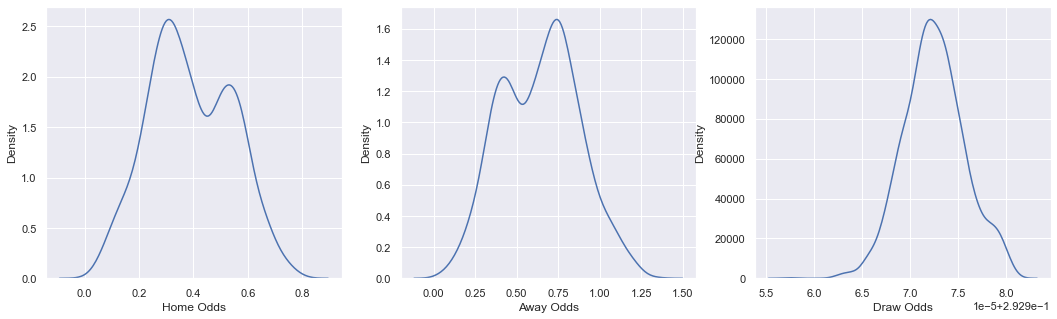

In [176]:
# Let's now get a kernel density plot of the boxcox transformed variables
fig, ax = plt.subplots(1, 3, figsize=(18,5))
sns.kdeplot(data=dfb['Home Odds'], ax=ax[0])
sns.kdeplot(data=dfb['Away Odds'], ax=ax[1])
sns.kdeplot(data=dfb['Draw Odds'], ax=ax[2]);

Kernel density plots are much more normal looking, except for the little dip in the first two plots. Let's have a quick look at the probability plots:

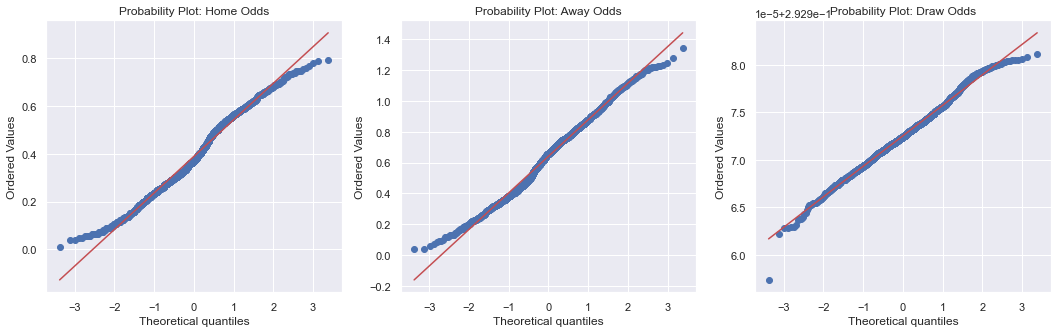

In [177]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
# sns.kdeplot(data=dfb['Home Odds'], ax=ax[0])
prob1 = stats.probplot(dfb['Home Odds'], dist=stats.norm, plot=ax[0])
prob2 = stats.probplot(dfb['Away Odds'], dist=stats.norm, plot=ax[1])
prob3 = stats.probplot(dfb['Draw Odds'], dist=stats.norm, plot=ax[2])
ax[0].set_title("Probability Plot: Home Odds")
ax[1].set_title("Probability Plot: Away Odds")
ax[2].set_title("Probability Plot: Draw Odds");

The middle of all 3 plots tend to show normality, however, the tails do show some outliers which is bound to effect our results. I'm not going to delete any outliers since important information will be lost. Instead, I will be using the Robust Scalar to counteract for outliers in the data. 

Now, since the data is looking more normal, I am wanting to apply PCA to the 3 odds columns. But first lets get a visual representation of these columns.

In [178]:
fig = px.scatter_3d(pd.concat([dfb, y1_train], axis=1), x='Home Odds', y='Away Odds', z='Draw Odds',
                    color='Winner')
fig.show()

Looking at the data, it kind of looks like a boomerang funny enough, but it certainly does look like it would be appropriate in this case to perform PCA. 

In [179]:
# PCA
pca = PCA() # all components set by default
pca.fit(dfb[['Home Odds', 'Away Odds', 'Draw Odds']])

print(pca.explained_variance_ratio_)

[9.98845052e-01 1.15494778e-03 8.59874139e-11]


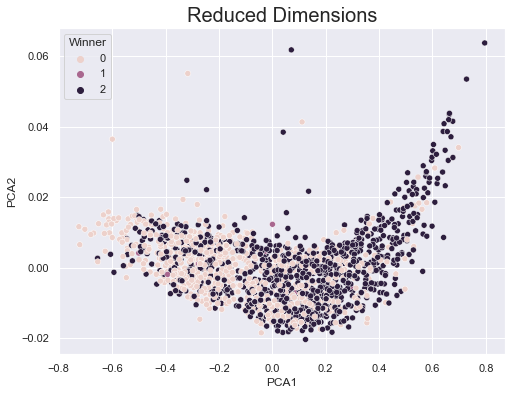

In [180]:
# We'll use the first two components, since the third barely explains any information about the data
### NOTE: we could use one, but I want as much information as possible, so we'll go with 2
pca_Xscores = pca.transform(dfb[['Home Odds', 'Away Odds', 'Draw Odds']])[:,0:2]

df_pca_Xscores = pd.DataFrame(pca_Xscores, columns=['PCA1', 'PCA2'])
df_pca_Xscores_Winner = pd.concat([df_pca_Xscores, y1_train.reset_index(drop=True)], axis=1)

# Plotting the new reduced dimensions
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca_Xscores_Winner, x='PCA1', y='PCA2', hue='Winner')
plt.title('Reduced Dimensions', fontsize=20);

Going forth, will use only these 2 components instead of the 3 types of odds. 

Below, I have created a function that will automate the process of performing a Boxcox Transformation as well as fitting a PCA model on the training data. It then uses these computed properties to update the unseen data, i.e. on the validation and testing sets.

In [181]:
def boxcox_pca(X_train, X_val, X_test, cols):
    Xtrain, Xval, Xtest = X_train.copy(), X_val.copy(), X_test.copy()
    optimal_lambdas = dict()
    
    for i in ['train', 'val', 'test']:
        if i == 'train':
            # BoxCox Transformation
            for col in cols:
                xt, best_lambda = stats.boxcox(Xtrain[col])
                optimal_lambdas[col] = best_lambda
                Xtrain[col] = xt
    
            pca = PCA()
            pca.fit(Xtrain[cols])
            Xtrain_pcaXscores = pca.transform(Xtrain[cols])[:,0:2] # first 2 PCs
            df_Xtrain_pcaXscores = pd.DataFrame(Xtrain_pcaXscores, columns=['PCA1', 'PCA2']) # convert above to df
            Xtrain = Xtrain.drop(cols, axis=1).reset_index(drop=True)
            Xtrain = pd.concat([Xtrain, df_Xtrain_pcaXscores], axis=1)
            
        elif i == 'val':
            for col, lambda_ in optimal_lambdas.items():
                Xval[col] = Xval[col].apply(lambda x: (x**lambda_ - 1)/lambda_)
                
            Xval_pcaXscores = pca.transform(Xval[cols])[:,0:2] # first 2 PCs
            df_Xval_pcaXscores = pd.DataFrame(Xval_pcaXscores, columns=['PCA1', 'PCA2']) # convert above to df
            Xval = Xval.drop(cols, axis=1).reset_index(drop=True)
            Xval = pd.concat([Xval, df_Xval_pcaXscores], axis=1)
        
        else:
            for col, lambda_ in optimal_lambdas.items():
                Xtest[col] = Xtest[col].apply(lambda x: (x**lambda_ - 1)/lambda_)
                
            Xtest_pcaXscores = pca.transform(Xtest[cols])[:,0:2] # first 2 PCs
            df_Xtest_pcaXscores = pd.DataFrame(Xtest_pcaXscores, columns=['PCA1', 'PCA2']) # convert above to df
            Xtest = Xtest.drop(cols, axis=1).reset_index(drop=True)
            Xtest = pd.concat([Xtest, df_Xtest_pcaXscores], axis=1)
            
    return Xtrain, Xval, Xtest

In [182]:
X1_train_pca, X1_val_pca, X1_test_pca = boxcox_pca(X1_train, X1_val, X1_test, ['Home Odds', 'Away Odds', 'Draw Odds'])
X2_train_pca, X2_val_pca, X2_test_pca = boxcox_pca(X2_train, X2_val, X2_test, ['Home Odds', 'Away Odds', 'Draw Odds'])
X3_train_pca, X3_val_pca, X3_test_pca = boxcox_pca(X3_train, X3_val, X3_test, ['Home Odds', 'Away Odds', 'Draw Odds'])

<h4 style="color:dodgerblue">Standardisation</h4>

In [183]:
X1_train_std, X1_val_std, X1_test_std = X1_train_pca.copy(), X1_val_pca.copy(), X1_test_pca.copy()
X2_train_std, X2_val_std, X2_test_std = X2_train_pca.copy(), X2_val_pca.copy(), X2_test_pca.copy()
X3_train_std, X3_val_std, X3_test_std = X3_train_pca.copy(), X3_val_pca.copy(), X3_test_pca.copy()

scaler12 = ['Kick-off Time', 'Home Team', 'Away Team']
scaler_3 = ['Kick-off Time']

scaler1 = StandardScaler()
X1_train_std[scaler12] = scaler1.fit_transform(X1_train_std[scaler12])
X1_val_std[scaler12] = scaler1.transform(X1_val_std[scaler12])
X1_test_std[scaler12] = scaler1.transform(X1_test_std[scaler12])

scaler2 = StandardScaler()
X2_train_std[scaler12] = scaler2.fit_transform(X2_train_std[scaler12])
X2_val_std[scaler12] = scaler2.transform(X2_val_std[scaler12])
X2_test_std[scaler12] = scaler2.transform(X2_test_std[scaler12])

scaler3 = StandardScaler()
X3_train_std[scaler_3] = scaler3.fit_transform(X3_train_std[scaler_3])
X3_val_std[scaler_3] = scaler3.transform(X3_val_std[scaler_3])
X3_test_std[scaler_3] = scaler3.transform(X3_test_std[scaler_3])

<h4 style="color:dodgerblue">Normalisation</h4>

In [184]:
X1_train_n, X1_val_n, X1_test_n = X1_train_pca.copy(), X1_val_pca.copy(), X1_test_pca.copy()
X2_train_n, X2_val_n, X2_test_n = X2_train_pca.copy(), X2_val_pca.copy(), X2_test_pca.copy()
X3_train_n, X3_val_n, X3_test_n = X3_train_pca.copy(), X3_val_pca.copy(), X3_test_pca.copy()

minmaxscaler12 = ['Kick-off Time', 'Home Team', 'Away Team']
minmaxscalar3 = ['Kick-off Time']

minmaxscaler1 = MinMaxScaler()
X1_train_n[minmaxscaler12] = minmaxscaler1.fit_transform(X1_train_n[minmaxscaler12])
X1_val_n[minmaxscaler12] = minmaxscaler1.transform(X1_val_n[minmaxscaler12])
X1_test_n[minmaxscaler12] = minmaxscaler1.transform(X1_test_n[minmaxscaler12])

minmaxscaler2 = MinMaxScaler()
X2_train_n[minmaxscaler12] = minmaxscaler2.fit_transform(X2_train_n[minmaxscaler12])
X2_val_n[minmaxscaler12] = minmaxscaler2.transform(X2_val_n[minmaxscaler12])
X2_test_n[minmaxscaler12] = minmaxscaler2.transform(X2_test_n[minmaxscaler12])

minmaxscaler3 = MinMaxScaler()
X3_train_n[minmaxscalar3] = minmaxscaler3.fit_transform(X3_train_n[minmaxscalar3])
X3_val_n[minmaxscalar3] = minmaxscaler3.transform(X3_val_n[minmaxscalar3])
X3_test_n[minmaxscalar3] = minmaxscaler3.transform(X3_test_n[minmaxscalar3])

<h2>Machine Learning</h2>

<h3 style='color:orange'>PyTorch</h3>

In [185]:
# Transforming data to relevant tensors (doing 1 dataset at time, so uncomment another function and re-run)
def train_val_test_pytorch(X_train, X_val, X_test, y_train, y_val, y_test):
    global train_loader, val_loader, test_loader
    
    train = data_utils.TensorDataset(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train)))
    train_loader = data_utils.DataLoader(train, batch_size = 64, shuffle = True)

    val = data_utils.TensorDataset(torch.Tensor(np.array(X_val)), torch.Tensor(np.array(y_val)))
    val_loader = data_utils.DataLoader(val, batch_size = 64, shuffle = True)

    test = data_utils.TensorDataset(torch.Tensor(np.array(X_test)), torch.Tensor(np.array(y_test)))
    test_loader = data_utils.DataLoader(test, batch_size = 64, shuffle = True)

# train_val_test_pytorch(X1_train_pca, X1_val_pca, X1_test_pca, y1_train, y1_val, y1_test)
# train_val_test_pytorch(X2_train_pca, X2_val_pca, X2_test_pca, y2_train, y2_val, y2_test)
# train_val_test_pytorch(X3_train_pca, X3_val_pca, X3_test_pca, y3_train, y3_val, y3_test)

# train_val_test_pytorch(X1_train_std, X1_val_std, X1_test_std, y1_train, y1_val, y1_test)
# train_val_test_pytorch(X2_train_std, X2_val_std, X2_test_std, y2_train, y2_val, y2_test)
# train_val_test_pytorch(X3_train_std, X3_val_std, X3_test_std, y3_train, y3_val, y3_test)

# train_val_test_pytorch(X1_train_n, X1_val_n, X1_test_n, y1_train, y1_val, y1_test)
train_val_test_pytorch(X2_train_n, X2_val_n, X2_test_n, y2_train, y2_val, y2_test)
# train_val_test_pytorch(X3_train_n, X3_val_n, X3_test_n, y3_train, y3_val, y3_test)

In [186]:
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

In [187]:
# Creating the Model
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__() 
        self.l1 = nn.Linear(6, 20)
#         self.l1 = nn.Linear(37, 40)
        self.d1 = nn.Dropout(p=0.3)
        
        self.l2 = nn.Linear(20, 10)
#         self.l2 = nn.Linear(40, 10)
        self.d2 = nn.Dropout(p=0.3)
        
        self.l3 = nn.Linear(10, 3)
        
    def forward(self, x):
        x = self.d1(F.relu(self.l1(x)))
        x = self.d2(F.relu(self.l2(x)))
        x = F.log_softmax(self.l3(x))
        return x

In [188]:
# Train/Validate Model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    
    liveloss = PlotLosses()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # max along rows
                    loss = criterion(outputs, labels.long())
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0) # avg_loss per batch_size * batch_size
                running_corrects += torch.sum(preds == labels.data) 
                        
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
#             print(f"{phase} Epoch Loss: {epoch_loss}   |   {phase} Epoch Accuracy: {epoch_acc}")
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            
            prefix = ''
            if phase == 'val':
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.send()
    
    model.load_state_dict(best_model_weights)

In [189]:
# Setting up arguments for train_model()
# torch.manual_seed(9)

model = Net()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [190]:
# Test the model
def test_model(model, criterion):
    model.eval()
    
    running_loss = 0.0
    running_correct = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.long())
            
            running_loss += loss.item() * inputs.size(0)
            running_correct += torch.sum(preds == labels.data)
        
        total_loss = running_loss / len(dataloaders['test'].dataset)
        total_correct = running_correct / len(dataloaders['test'].dataset)
        
        print('Testing Accuracy: %.4f   |   Testing Error: %.4f' % (total_correct, total_loss))

We'll now test the model on the 2nd PCA dataset out of the 3. Please see the "KFold Cross Validation Model" part below to see why I chose this dataset over the other 8.

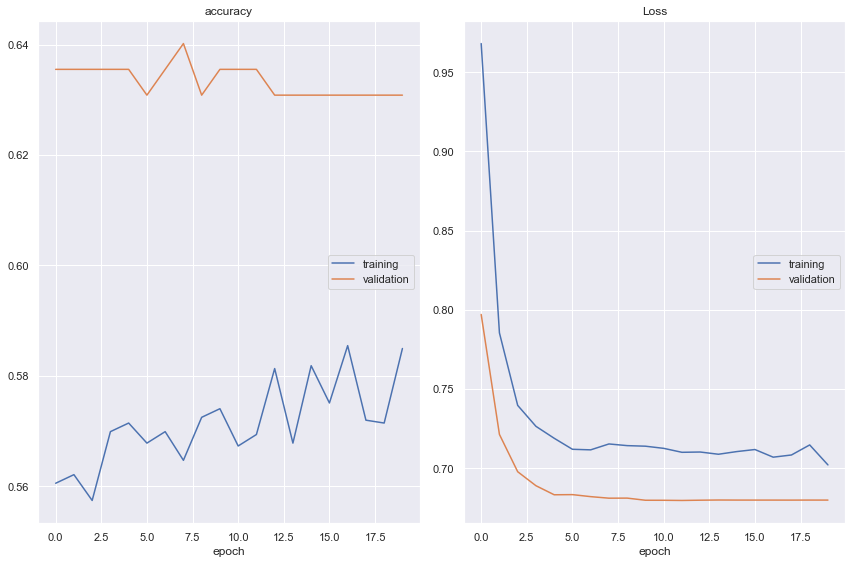

accuracy
	training         	 (min:    0.557, max:    0.585, cur:    0.585)
	validation       	 (min:    0.631, max:    0.640, cur:    0.631)
Loss
	training         	 (min:    0.702, max:    0.968, cur:    0.702)
	validation       	 (min:    0.680, max:    0.797, cur:    0.680)


In [191]:
train_model(model, criterion, optimizer, exp_lr_scheduler)

In [192]:
# And test the model
test_model(model, criterion)

Testing Accuracy: 0.5672   |   Testing Error: 0.6858


So now that we have trained, validated and tested our model, lets set up our prediction process, in which we'll first transform the data so its model ready.

<h3 style="color:dodgerblue">Model Prediction Process</h3>

For this stage, we'll now convert a given observation into the required format for the model to make a prediction

In [193]:
def pickle_boxcox_pca(X_train, cols):
    global optimal_lambdas1
    Xtrain1= X_train.copy()
    optimal_lambdas1 = dict()
    
    # BoxCox Transformation
    for col in cols:
        xt, best_lambda = stats.boxcox(Xtrain1[col])
        optimal_lambdas1[col] = best_lambda
        Xtrain1[col] = xt

    pca = PCA()
    pca.fit(Xtrain1[cols])
    
    # Save the fitted model
    with open('pca.pkl', 'wb') as pickle_file:
        pickle.dump(pca, pickle_file)
    
    Xtrain_pcaXscores = pca.transform(Xtrain1[cols])[:,0:2] # first 2 PCs
    df_Xtrain_pcaXscores = pd.DataFrame(Xtrain_pcaXscores, columns=['PCA1', 'PCA2']) # convert above to df
    Xtrain1 = Xtrain1.drop(cols, axis=1).reset_index(drop=True)
    Xtrain1 = pd.concat([Xtrain1, df_Xtrain_pcaXscores], axis=1)

In [194]:
pickle_boxcox_pca(X2_train, ['Home Odds', 'Draw Odds', 'Away Odds'])

In [195]:
#You'll need the variables: optimal_lambdas1 from 2 cells above and df_fe2_catEnc

arr1 = ["7:30", "Panthers", "Bulldogs", "No", "1.50", "17.69", "4.50"]

def transform_array(arr, model):
    trans_arr = []
    
    # Converting 12hr time format into integer mapping
    hour, minute = list(map(int, arr[0].split(':')))
    # Converting to minute
    if hour != 12:
        mins = (hour + 12) * 60 + minute
    else:
        mins = hour * 60 + minute
    for bin_ in bins:
        lb, ub = bin_
        if lb <= mins < ub:
            kot = float((lb - 720)/10/54)
            trans_arr.append(kot)
    
    # Home Team
    trans_arr.append(df_fe2_catEnc['Home Team'][arr[1]]/15)
    # Away Team
    trans_arr.append(df_fe2_catEnc['Away Team'][arr[2]]/15)
    # Play Off Game
    trans_arr.append(df_fe2_catEnc['Play-off Game'][arr[3]])
    
    # BoxCox Transform + PCA
    homeOdds = (float(arr[4])**optimal_lambdas['Home Odds'] - 1) / optimal_lambdas['Home Odds']
    drawOdds = (float(arr[5])**optimal_lambdas['Draw Odds'] - 1) / optimal_lambdas['Draw Odds']
    awayOdds = (float(arr[6])**optimal_lambdas['Away Odds'] - 1) / optimal_lambdas['Away Odds']
    odds = [homeOdds, drawOdds, awayOdds]
    
    with open('pca.pkl', 'rb') as pickle_file:
        pca = pickle.load(pickle_file)
        pca_Xscores = pca.transform([odds])[0][0:2]
        trans_arr = trans_arr + list(pca_Xscores)
        pickle_file.close()
    
    trans_arr = torch.tensor(trans_arr, dtype=torch.float32)
    _, pred = torch.max(model(trans_input), 0)
    results = ['Away Win', 'Draw', 'Home Win']
    pred = results[int(pred)]
    return pred
    
transform_array(arr1, model)

'Home Win'

<h3 style="color:lightgreen">KFold Cross Validation Model</h3>

Below is a model I have made that allows you to perform KFold Cross Validation. The model is trained `KFold` number of times for a total of `epochs` epochs per KFold. 

For each KFold, it will calculate the minimum validation loss and maximum validation accuracy. Finally, at the end, it will average the two across each of the `KFold` Kfolds. 

Please note, I wouldn't recommend performing this computation on such a large dataset as it will be very slow.
Also note that I already split the dataset between train/val/test. Combining train and val together in this step would even provide better results, since there would be more data, however, in this circumstance I have just applied it to the train split.

In [196]:
def train_model_kfold(X_train, y_train, model, criterion, optimizer, scheduler, epochs=20):
    
    kfold_errors = []
    kfold_accuracies = []
    kfold = KFold(n_splits=10)
    
    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)): # default 5 splits
        X_train_fold = X_train.iloc[train_index]
        X_test_fold = X_train.iloc[val_index]
        y_train_fold = y_train.iloc[train_index]
        y_test_fold = y_train.iloc[val_index]
        
        train = torch.utils.data.TensorDataset(torch.Tensor(np.array(X_train_fold)), torch.Tensor(np.array(y_train_fold)))
        test = torch.utils.data.TensorDataset(torch.Tensor(np.array(X_test_fold)), torch.Tensor(np.array(y_test_fold)))
        train_loader = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = False)
        test_loader = torch.utils.data.DataLoader(test, batch_size = 32, shuffle = False)
        
        # Creating new instance of model to reset parameters for each fold
        model = Net()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        best_acc_test = 0.0
        best_error_test = 1.0
        
        for epoch in range(epochs):
#             print('\nEpoch {} / {} \nFold number {} / {}'.format(epoch + 1, epochs, fold + 1 , KFold().get_n_splits()))
            
            running_loss_train = 0.0
            running_corrects_train = 0
            running_loss_test = 0.0
            running_correct_test = 0
            
            model.train()
            for batch_index, (X_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1) # max along rows
                loss = criterion(outputs, y_batch.long())
                loss.backward()
                optimizer.step()
                running_loss_train += loss.item() * X_batch.size(0) # avg_loss per batch_size * batch_size
                running_corrects_train += torch.sum(preds == y_batch.data).numpy()
            scheduler.step()
                
            model.eval()
            with torch.no_grad():
                for batch_index_test, (X_batch_test, y_batch_test) in enumerate(test_loader):
                    outputs = model(X_batch_test)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, y_batch_test.long())
                    running_loss_test += loss.item() * X_batch_test.size(0)
                    running_correct_test += torch.sum(preds == y_batch_test.data).numpy()
                total_loss = running_loss_test / len(test_loader.dataset)
                total_correct = running_correct_test / len(test_loader.dataset)      
                
            epoch_loss_train = running_loss_train / len(train_loader.dataset)
            epoch_acc_train = running_corrects_train / len(train_loader.dataset)
            epoch_loss_test = total_loss
            epoch_acc_test = total_correct
            
            if epoch_acc_test > best_acc_test:
                best_acc_test = epoch_acc_test
                
            if best_error_test > epoch_loss_test:
                best_error_test = epoch_loss_test
            
#             print(f"Epoch Loss Training: {epoch_loss_train}   |   Epoch Accuracy Training: {epoch_acc_train}",
#                   f"Epoch Loss Testing: {epoch_loss_test}   |   Epoch Accuracy Testing: {epoch_acc_test}")
        
        kfold_accuracies.append(best_acc_test)
        kfold_errors.append(best_error_test)
    
        print(f"\nFold Number {fold + 1} / {kfold.get_n_splits()}",
              f"\nCV KFold accuracy: {np.array(best_acc_test).round(4)}",
              f"\nCV Kfold error: {np.array(best_error_test).round(4)}")
    
    print(f"\nOverall CV Statistics",
          f"\nCV KFold accuracy: {np.mean(kfold_accuracies).round(4)}",
          f"\nCV Kfold error: {np.mean(kfold_errors).round(4)}")

In [197]:
# The first one yielded the best results.

# train_model_kfold(X1_train_pca, y1_train, model, criterion, optimizer, exp_lr_scheduler)
# train_model_kfold(X2_train_pca, y2_train, model, criterion, optimizer, exp_lr_scheduler)
# train_model_kfold(X3_train_pca, y3_train, model, criterion, optimizer, exp_lr_scheduler)

# train_model_kfold(X1_train_std, y1_train, model, criterion, optimizer, exp_lr_scheduler)
# train_model_kfold(X2_train_std, y2_train, model, criterion, optimizer, exp_lr_scheduler)
# train_model_kfold(X3_train_std, y3_train, model, criterion, optimizer, exp_lr_scheduler)

# train_model_kfold(X1_train_n, y1_train, model, criterion, optimizer, exp_lr_scheduler)
train_model_kfold(X2_train_n, y2_train, model, criterion, optimizer, exp_lr_scheduler)
# train_model_kfold(X3_train_n, y3_train, model, criterion, optimizer, exp_lr_scheduler)


Fold Number 1 / 10 
CV KFold accuracy: 0.6995 
CV Kfold error: 0.6566

Fold Number 2 / 10 
CV KFold accuracy: 0.6943 
CV Kfold error: 0.6137

Fold Number 3 / 10 
CV KFold accuracy: 0.6995 
CV Kfold error: 0.6435

Fold Number 4 / 10 
CV KFold accuracy: 0.6736 
CV Kfold error: 0.6386

Fold Number 5 / 10 
CV KFold accuracy: 0.6684 
CV Kfold error: 0.6873

Fold Number 6 / 10 
CV KFold accuracy: 0.625 
CV Kfold error: 0.711

Fold Number 7 / 10 
CV KFold accuracy: 0.6771 
CV Kfold error: 0.646

Fold Number 8 / 10 
CV KFold accuracy: 0.6302 
CV Kfold error: 0.6885

Fold Number 9 / 10 
CV KFold accuracy: 0.6562 
CV Kfold error: 0.6629

Fold Number 10 / 10 
CV KFold accuracy: 0.6823 
CV Kfold error: 0.6853

Overall CV Statistics 
CV KFold accuracy: 0.6706 
CV Kfold error: 0.6633


After observing the results for all 9 cross validations, the one that performed best overall with the lowest average error (marginally) and highest average accuracy (marginally) was the 2nd normalisied dataset. Though, sometimes the 3rd normalised dataset performed better than the 2nd via kfold cv. However, we'll stick with the 2nd one.